In [ ]:
import fastformer
from transformers import AutoConfig, AutoModelForCausalLM, PretrainedConfig
from transformers import TrainingArguments, Trainer

# reload to allow for easy editing of fastformer code
import importlib
importlib.reload(fastformer)
FastformerForCausalLM = fastformer.FastformerForCausalLM

In [ ]:
class FastformerForCausalLMConfig(PretrainedConfig):
    model_type = "FastformerForCausalLM"
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

AutoConfig.register("FastformerForCausalLM", FastformerForCausalLMConfig)
AutoModelForCausalLM.register(FastformerForCausalLMConfig, FastformerForCausalLM)

In [ ]:
# character tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/byt5-small")

In [ ]:
from datasets import load_dataset

wiki = load_dataset("wikitext", "wikitext-2-raw-v1")

import numpy as np
def preprocess_function(examples):
    data = tokenizer(examples["text"], padding = 'max_length',
                     truncation=True, max_length = 256, return_tensors = 'np')
    
    # shift outputs
    labels = np.roll(data["input_ids"], -1)
    labels[:,-1] = 0
    data["labels"] = labels
    return data

lm_dataset = wiki.map(
    preprocess_function,
    remove_columns=wiki["train"].column_names,
    batched = True
).shuffle(32)

lm_dataset.set_format('pt')

Reusing dataset wikitext (C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-df0ddbf9250d3f5b.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-a1b2d4de89c3cbb5.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-e05a374bd6f995bb.arrow
Loading cached shuffled indices for dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-a75d0cb233cce882.arrow
Loading cached shuffled indices for dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499

In [ ]:
# hyperparameters

training_args = TrainingArguments(
    output_dir="./results",
    logging_strategy = "epoch",
    evaluation_strategy="epoch",
    report_to = "none",
    learning_rate=5e-4,
    num_train_epochs = 50,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    save_strategy = "no"
)

config = FastformerForCausalLMConfig(
    hidden_size = 256, vocab_size = len(tokenizer),
    max_position_embeddings = 256, groups = 2, kernel_size = 4,
    convolve = False, num_hidden_layers = 6, hidden_dropout_prob= 0.1
)

# 1. Additive attention adapted for causal language modeling

In [ ]:
model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

4113792

In [ ]:
trainer1 = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"]
)

trainer1.train()

***** Running training *****
  Num examples = 36718
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 114750


Epoch,Training Loss,Validation Loss
1,2.495400,1.875814
2,1.861500,1.838007
3,1.826700,1.797887
4,1.778700,1.725000
5,1.703500,1.641362
6,1.629600,1.575506
7,1.580900,1.549470
8,1.548000,1.528766
9,1.524900,1.511413
10,1.507900,1.503030


***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** 

TrainOutput(global_step=114750, training_loss=1.4677971005242374, metrics={'train_runtime': 8523.2856, 'train_samples_per_second': 215.398, 'train_steps_per_second': 13.463, 'total_flos': 0.0, 'train_loss': 1.4677971005242374, 'epoch': 50.0})

# 2. Add convolution

In [ ]:
config.convolve = True

# decrease by a layer to make room for the convolutional layer
config.num_hidden_layers = 5

model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

4113536

In [ ]:
trainer2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"]
)

trainer2.train()

***** Running training *****
  Num examples = 36718
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 114750


Epoch,Training Loss,Validation Loss
1,2.687000,1.662102
2,1.627200,1.559966
3,1.552900,1.525201
4,1.514700,1.500106
5,1.491300,1.491890
6,1.473600,1.479720
7,1.460300,1.474157
8,1.449400,1.469321
9,1.440400,1.462579
10,1.432500,1.456752


***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** 

TrainOutput(global_step=114750, training_loss=1.4096851149748093, metrics={'train_runtime': 9229.5354, 'train_samples_per_second': 198.916, 'train_steps_per_second': 12.433, 'total_flos': 0.0, 'train_loss': 1.4096851149748093, 'epoch': 50.0})

# 3. GPT2 (comparision)

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel
config = GPT2Config(n_embd = 256, vocab_size=len(tokenizer),
                    n_positions = 256, n_layer = 5, n_head = 1,
                    resid_pdrop = .1, embd_pdrop = .1, attn_pdrop = .1
                   )
model = GPT2LMHeadModel(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

4113152

In [ ]:
trainer3 = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"]
)

trainer3.train()

***** Running training *****
  Num examples = 36718
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 114750


Epoch,Training Loss,Validation Loss
1,1.208100,1.099498
2,1.066500,1.010980
3,1.003500,0.958221
4,0.960700,0.928466
5,0.930600,0.908607
6,0.907500,0.893118
7,0.889000,0.882933
8,0.873800,0.872631
9,0.861100,0.867735
10,0.850400,0.858833


***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4358
  Batch size = 16
***** 

TrainOutput(global_step=114750, training_loss=0.7978302015250545, metrics={'train_runtime': 8645.7695, 'train_samples_per_second': 212.347, 'train_steps_per_second': 13.272, 'total_flos': 1.11368323596288e+16, 'train_loss': 0.7978302015250545, 'epoch': 50.0})

# Results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

loss1 = pd.DataFrame(trainer1.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss2 = pd.DataFrame(trainer2.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss3 = pd.DataFrame(trainer3.state.log_history[1::2]).set_index("epoch")["eval_loss"]
results = pd.DataFrame({"Additive Attention (4.11M parameters)": loss1,
                        "Convolutional Additive Attention (4.11M parameters)": loss2,
                        "GPT2 (4.11M parameters)": loss3
                       })
results.to_csv("results.csv")

BPC_results = np.log2(np.exp(results))
BPC_results

,Additive Attention (4.11M parameters),Convolutional Additive Attention (4.11M parameters),GPT2 (4.11M parameters)
epoch,,,
1.0,2.706227,2.397907,1.586240
2.0,2.651684,2.250555,1.458535
3.0,2.593803,2.200400,1.382421
4.0,2.488649,2.164195,1.339493
5.0,2.367985,2.152342,1.310844
6.0,2.272975,2.134785,1.288497
7.0,2.235412,2.126760,1.273802
8.0,2.205542,2.119782,1.258940
9.0,2.180509,2.110056,1.251877


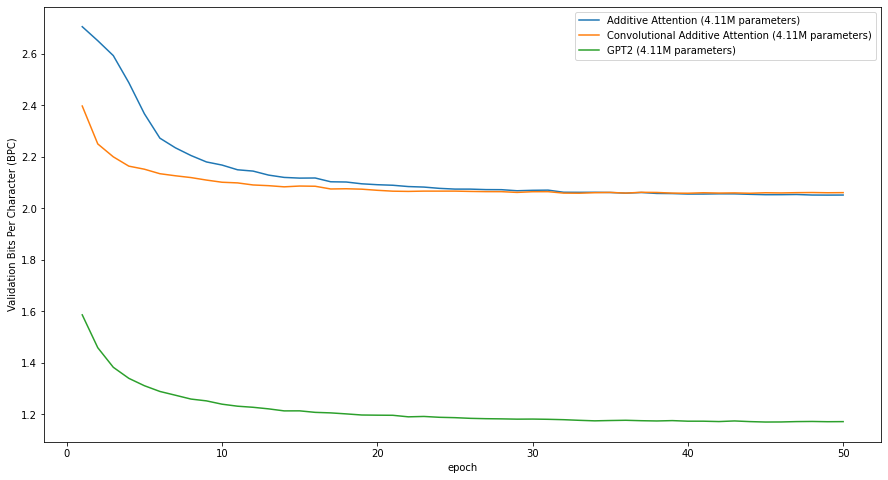

In [ ]:
BPC_results.plot()

plt.ylabel("Validation Bits Per Character (BPC)")
#plt.axhline(y=BPC_results["Additive Attention (4.15M parameters)"].min(), linestyle='--', label = "Minimum Additive Attention Validation BPC")
plt.legend()
plt.show()

# Appendix

In [ ]:
import importlib
import fastformer
importlib.reload(fastformer)
FastformerForCausalLM = fastformer.FastformerForCausalLM

In [ ]:
import pandas as pd
train_loss = pd.DataFrame(trainer1.state.log_history[0::2])
eval_loss = pd.DataFrame(trainer1.state.log_history[1::2])
display(train_loss, eval_loss)

# Reformer

In [ ]:
del model
del trainer
torch.cuda.empty_cache()

In [ ]:
from transformers import ReformerConfig, ReformerModelWithLMHead
config = ReformerConfig(hidden_size = 256, vocab_size=len(tokenizer),
                       num_hidden_layers = 4, attention_head_size = 64, num_attention_heads = 4,
                       attn_layers = ['local', 'lsh'], axial_pos_embds_dim = [128, 128], axial_pos_shape = [16, 16],
                       feed_forward_size = 4*256, max_position_embeddings = 256,
                       
                       is_decoder=True, block_size = 16
                   )
model = ReformerModelWithLMHead(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
model = model.cpu()
input_ids = lm_dataset["train"][10]["input_ids"].reshape(1, -1).cpu()
attention_mask = lm_dataset["train"][10]["attention_mask"].reshape(1, -1).cpu()
labels = lm_dataset["train"][10]["labels"].reshape(1, -1).cpu()
logits = model(input_ids, labels, attention_mask)

In [ ]:
model = model.train()

In [ ]:
import torch
predictions = torch.argmax(logits, dim=-1)
tokenizer.batch_decode(predictions)

In [ ]:
tokenizer.decode(lm_dataset["test"][0]["labels"])